# Section: Federated Learning

# Lesson: Introducing Federated Learning

Federated Learning is a technique for training Deep Learning models on data to which you do not have access. Basically:

Federated Learning: Instead of bringing all the data to one machine and training a model, we bring the model to the data, train it locally, and merely upload "model updates" to a central server.

Use Cases:

    - app company (Texting prediction app)
    - predictive maintenance (automobiles / industrial engines)
    - wearable medical devices
    - ad blockers / autotomplete in browsers (Firefox/Brave)
    
Challenge Description: data is distributed amongst sources but we cannot aggregated it because of:

    - privacy concerns: legal, user discomfort, competitive dynamics
    - engineering: the bandwidth/storage requirements of aggregating the larger dataset

# Lesson: Introducing / Installing PySyft

In order to perform Federated Learning, we need to be able to use Deep Learning techniques on remote machines. This will require a new set of tools. Specifically, we will use an extensin of PyTorch called PySyft.

### Install PySyft

The easiest way to install the required libraries is with [Conda](https://docs.conda.io/projects/conda/en/latest/user-guide/overview.html). Create a new environment, then install the dependencies in that environment. In your terminal:

```bash
conda create -n pysyft python=3
conda activate pysyft # some older version of conda require "source activate pysyft" instead.
conda install jupyter notebook
pip install syft
pip install numpy
```

If you have any errors relating to zstd - run the following (if everything above installed fine then skip this step):

```
pip install --upgrade --force-reinstall zstd
```

and then retry installing syft (pip install syft).

If you are using Windows, I suggest installing [Anaconda and using the Anaconda Prompt](https://docs.anaconda.com/anaconda/user-guide/getting-started/) to work from the command line. 

With this environment activated and in the repo directory, launch Jupyter Notebook:

```bash
jupyter notebook
```

and re-open this notebook on the new Jupyter server.

If any part of this doesn't work for you (or any of the tests fail) - first check the [README](https://github.com/OpenMined/PySyft.git) for installation help and then open a Github Issue or ping the #beginner channel in our slack! [slack.openmined.org](http://slack.openmined.org/)

In [1]:
import torch as th

In [2]:
x = th.tensor([1,2,3,4,5])
x

tensor([1, 2, 3, 4, 5])

In [3]:
y = x + x

In [4]:
print(y)

tensor([ 2,  4,  6,  8, 10])


In [5]:
import syft as sy

In [6]:
hook = sy.TorchHook(th)

In [7]:
th.tensor([1,2,3,4,5])

tensor([1, 2, 3, 4, 5])

# Lesson: Basic Remote Execution in PySyft

## PySyft => Remote PyTorch

The essence of Federated Learning is the ability to train models in parallel on a wide number of machines. Thus, we need the ability to tell remote machines to execute the operations required for Deep Learning.

Thus, instead of using Torch tensors - we're now going to work with **pointers** to tensors. Let me show you what I mean. First, let's create a "pretend" machine owned by a "pretend" person - we'll call him Bob.

In [8]:
bob = sy.VirtualWorker(hook, id="bob")

In [9]:
bob._objects

{}

In [10]:
x = th.tensor([1,2,3,4,5])

In [11]:
x = x.send(bob)

In [12]:
bob._objects

{41671980356: tensor([1, 2, 3, 4, 5])}

In [13]:
x.location

<VirtualWorker id:bob #tensors:1>

In [14]:
x.id_at_location

41671980356

In [15]:
x.id

30970588276

In [16]:
x.owner

<VirtualWorker id:me #tensors:0>

In [17]:
hook.local_worker

<VirtualWorker id:me #tensors:0>

In [18]:
x

(Wrapper)>[PointerTensor | me:30970588276 -> bob:41671980356]

In [19]:
x = x.get()
x

tensor([1, 2, 3, 4, 5])

In [20]:
bob._objects

{}

# Project: Playing with Remote Tensors

In this project, I want you to .send() and .get() a tensor to TWO workers by calling .send(bob,alice). This will first require the creation of another VirtualWorker called alice.

In [21]:
# try this project here!

In [22]:
alice = sy.VirtualWorker(hook, id='alice')
bob = sy.VirtualWorker(hook, id='bob')
x = th.tensor([1,2,3,4,5])

In [23]:
x = x.send(alice, bob)

In [24]:
x.id

30536684341

In [25]:
x.location

In [26]:
alice._objects

{47580621359: tensor([1, 2, 3, 4, 5])}

In [27]:
bob._objects

{15370674848: tensor([1, 2, 3, 4, 5])}

In [28]:
x

(Wrapper)>[MultiPointerTensor]
	-> (Wrapper)>[PointerTensor | me:27989561047 -> alice:47580621359]
	-> (Wrapper)>[PointerTensor | me:97631634169 -> bob:15370674848]

In [29]:
x = x.get()

In [30]:
x

[tensor([1, 2, 3, 4, 5]), tensor([1, 2, 3, 4, 5])]

# Lesson: Introducing Remote Arithmetic

In [31]:
x = th.tensor([1,2,3,4,5]).send(bob)
y = th.tensor([1,1,1,1,1]).send(bob)

In [32]:
x

(Wrapper)>[PointerTensor | me:64407898154 -> bob:73914328329]

In [33]:
y

(Wrapper)>[PointerTensor | me:54814775710 -> bob:92014501963]

In [34]:
z = x + y

In [35]:
z

(Wrapper)>[PointerTensor | me:9305149754 -> bob:82721850079]

In [36]:
z = z.get()
z

tensor([2, 3, 4, 5, 6])

In [37]:
z = th.add(x,y)
z

(Wrapper)>[PointerTensor | me:40670596739 -> bob:35330949234]

In [38]:
z = z.get()
z

tensor([2, 3, 4, 5, 6])

In [39]:
x = th.tensor([1.,2,3,4,5], requires_grad=True).send(bob)
y = th.tensor([1.,1,1,1,1], requires_grad=True).send(bob)

In [40]:
z = (x + y).sum()

In [41]:
z.backward()

(Wrapper)>[PointerTensor | me:57864560797 -> bob:93577231415]

In [42]:
x = x.get()

In [43]:
x

tensor([1., 2., 3., 4., 5.], requires_grad=True)

In [44]:
x.grad

tensor([1., 1., 1., 1., 1.])

# Project: Learn a Simple Linear Model

In this project, I'd like for you to create a simple linear model which will solve for the following dataset below. You should use only Variables and .backward() to do so (no optimizers or nn.Modules). Furthermore, you must do so with both the data and the model being located on Bob's machine.

In [45]:
# try this project here!

In [46]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
bob = sy.VirtualWorker(hook, id='bob')

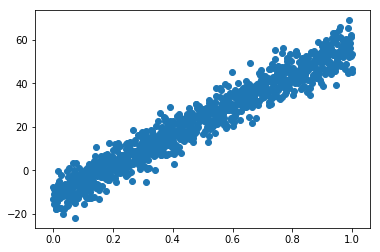

In [48]:
x = np.linspace(0, 1, 1000)
y = 70.0 * x + 5.0 * np.random.randn(x.shape[0]) - 12.0
plt.scatter(x, y)

In [49]:
# Create the tensors
x_t = th.tensor(x)
y_t = th.tensor(y)
coefs = th.tensor(np.random.randn(2), requires_grad=True)
eta = th.tensor(0.05)

# Send the tensors
x_remote = x_t.send(bob)
y_remote = y_t.send(bob)
coefs = coefs.send(bob)
eta = eta.send(bob)

In [50]:
# Operate remotely
x_big = th.cat((x_remote.view(-1, 1), th.ones_like(x_remote).view(-1, 1)), 1)

for i in range(1000):
    y_pred = x_big.mm(coefs.view(-1, 1))
    loss = ((y_remote.view(1, -1) - y_pred.view(1, -1)) ** 2).mean()
    loss.backward()
    
    # Gradient descent
    with th.no_grad():
        coefs -=  eta * coefs.grad
    coefs.grad.zero_()
    print(f'Iteration {i}. Loss: {loss.item()}')

Iteration 0. Loss: 999.3081356260319
Iteration 1. Loss: 833.3616824809856
Iteration 2. Loss: 705.962337868289
Iteration 3. Loss: 607.9680886911941
Iteration 4. Loss: 532.4076086915312
Iteration 5. Loss: 473.96481566086146
Iteration 6. Loss: 428.5858241118018
Iteration 7. Loss: 393.179229754075
Iteration 8. Loss: 365.38756348754106
Iteration 9. Loss: 343.41301521429017
Iteration 10. Loss: 325.8845407230234
Iteration 11. Loss: 311.75652494685596
Iteration 12. Loss: 300.23150831386613
Iteration 13. Loss: 290.70126224147447
Iteration 14. Loss: 282.70185664276335
Iteration 15. Loss: 275.8793969441987
Iteration 16. Loss: 269.96389706514657
Iteration 17. Loss: 264.7493564185964
Iteration 18. Loss: 260.0785677452683
Iteration 19. Loss: 255.83153241200364
Iteration 20. Loss: 251.91662655716374
Iteration 21. Loss: 248.26386487550374
Iteration 22. Loss: 244.81976394367058
Iteration 23. Loss: 241.54342526451836
Iteration 24. Loss: 238.40354839976618
Iteration 25. Loss: 235.3761533352994
Iteration 

Iteration 232. Loss: 38.84222758595037
Iteration 233. Loss: 38.664052509300625
Iteration 234. Loss: 38.48821702067354
Iteration 235. Loss: 38.31469039931837
Iteration 236. Loss: 38.143442327873565
Iteration 237. Loss: 37.97444288706999
Iteration 238. Loss: 37.807662550503494
Iteration 239. Loss: 37.643072179476405
Iteration 240. Loss: 37.48064301790653
Iteration 241. Loss: 37.32034668730316
Iteration 242. Loss: 37.16215518180893
Iteration 243. Loss: 37.0060408633068
Iteration 244. Loss: 36.85197645659146
Iteration 245. Loss: 36.699935044603784
Iteration 246. Loss: 36.54989006372825
Iteration 247. Loss: 36.401815299151835
Iteration 248. Loss: 36.25568488028401
Iteration 249. Loss: 36.11147327623672
Iteration 250. Loss: 35.96915529136392
Iteration 251. Loss: 35.82870606085939
Iteration 252. Loss: 35.69010104641281
Iteration 253. Loss: 35.553316031922314
Iteration 254. Loss: 35.41832711926378
Iteration 255. Loss: 35.28511072411543
Iteration 256. Loss: 35.15364357183748
Iteration 257. Loss

Iteration 520. Loss: 25.574536860475174
Iteration 521. Loss: 25.57057767806344
Iteration 522. Loss: 25.566670483033572
Iteration 523. Loss: 25.562814592747717
Iteration 524. Loss: 25.55900933353157
Iteration 525. Loss: 25.555254040556807
Iteration 526. Loss: 25.551548057724787
Iteration 527. Loss: 25.54789073755205
Iteration 528. Loss: 25.54428144105709
Iteration 529. Loss: 25.540719537648805
Iteration 530. Loss: 25.537204405016265
Iteration 531. Loss: 25.533735429019977
Iteration 532. Loss: 25.530312003584672
Iteration 533. Loss: 25.52693353059329
Iteration 534. Loss: 25.52359941978262
Iteration 535. Loss: 25.52030908864004
Iteration 536. Loss: 25.51706196230183
Iteration 537. Loss: 25.513857473452724
Iteration 538. Loss: 25.51069506222679
Iteration 539. Loss: 25.507574176109543
Iteration 540. Loss: 25.504494269841533
Iteration 541. Loss: 25.501454805323032
Iteration 542. Loss: 25.49845525151996
Iteration 543. Loss: 25.495495084371214
Iteration 544. Loss: 25.492573786696994
Iteration 

Iteration 795. Loss: 25.280975019505192
Iteration 796. Loss: 25.280870549996934
Iteration 797. Loss: 25.280767452260825
Iteration 798. Loss: 25.28066570828437
Iteration 799. Loss: 25.280565300291563
Iteration 800. Loss: 25.28046621073982
Iteration 801. Loss: 25.280368422316908
Iteration 802. Loss: 25.280271917937903
Iteration 803. Loss: 25.28017668074224
Iteration 804. Loss: 25.28008269409075
Iteration 805. Loss: 25.279989941562718
Iteration 806. Loss: 25.27989840695308
Iteration 807. Loss: 25.279808074269567
Iteration 808. Loss: 25.279718927729856
Iteration 809. Loss: 25.27963095175889
Iteration 810. Loss: 25.279544130986135
Iteration 811. Loss: 25.279458450242853
Iteration 812. Loss: 25.279373894559505
Iteration 813. Loss: 25.279290449163128
Iteration 814. Loss: 25.279208099474705
Iteration 815. Loss: 25.279126831106684
Iteration 816. Loss: 25.279046629860403
Iteration 817. Loss: 25.278967481723694
Iteration 818. Loss: 25.27888937286832
Iteration 819. Loss: 25.278812289647654
Iterati

In [51]:
# Retrieve the results
coefs = coefs.get()
x_big_local = th.cat([x_t.view(-1, 1), th.ones_like(x_t).view(-1, 1)], 1)
y_pred = x_big_local.mm(coefs.view(-1, 1))
coefs

tensor([ 69.9428, -11.8724], dtype=torch.float64, requires_grad=True)

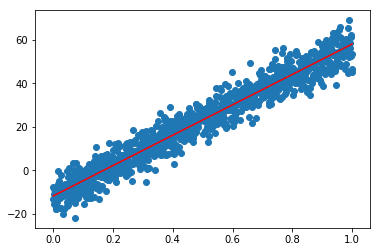

In [52]:
# Show the results
plt.scatter(x, y)
plt.plot(x, y_pred.data.numpy(), 'r')

# Lesson: Garbage Collection and Common Errors


In [53]:
bob = bob.clear_objects()

In [54]:
bob._objects

{}

In [55]:
x = th.tensor([1,2,3,4,5]).send(bob)

In [56]:
bob._objects

{}

In [57]:
del x

In [58]:
bob._objects

{}

In [59]:
x = th.tensor([1,2,3,4,5]).send(bob)

In [60]:
bob._objects

{}

In [61]:
x = "asdf"

In [62]:
bob._objects

{}

In [63]:
x = th.tensor([1,2,3,4,5]).send(bob)

In [64]:
x

(Wrapper)>[PointerTensor | me:60210675459 -> bob:70925856845]

In [65]:
bob._objects

{}

In [66]:
x = "asdf"

In [67]:
bob._objects

{}

In [68]:
del x

In [69]:
bob._objects

{}

In [70]:
bob = bob.clear_objects()
bob._objects

{}

In [71]:
for i in range(1000):
    x = th.tensor([1,2,3,4,5]).send(bob)

In [72]:
bob._objects

{}

In [73]:
x = th.tensor([1,2,3,4,5]).send(bob)
y = th.tensor([1,1,1,1,1])

In [74]:
z = x + y

TensorsNotCollocatedException: You tried to call a method involving two tensors where one tensor is actually locatedon another machine (is a PointerTensor). Call .get() on the PointerTensor or .send(bob) on the other tensor.

Tensor A: [PointerTensor | me:12044173080 -> bob:47129849739]
Tensor B: tensor([1, 1, 1, 1, 1])

In [75]:
x = th.tensor([1,2,3,4,5]).send(bob)
y = th.tensor([1,1,1,1,1]).send(alice)

In [76]:
z = x + y

TensorsNotCollocatedException: You tried to call __add__ involving two tensors which are not on the same machine! One tensor is on <VirtualWorker id:bob #tensors:0> while the other is on <VirtualWorker id:alice #tensors:1>. Use a combination of .move(), .get(), and/or .send() to co-locate them to the same machine.

# Lesson: Toy Federated Learning

Let's start by training a toy model the centralized way. This is about a simple as models get. We first need:

- a toy dataset
- a model
- some basic training logic for training a model to fit the data.

In [87]:
from torch import nn, optim

In [88]:
alice = sy.VirtualWorker(hook, id='alice')
bob = sy.VirtualWorker(hook, id='bob')

In [89]:
# A Toy Dataset
data = th.tensor([[1.,1],[0,1],[1,0],[0,0]], requires_grad=True)
target = th.tensor([[1.],[1], [0], [0]], requires_grad=True)

In [90]:
# A Toy Model
model = nn.Linear(2,1)

In [91]:
opt = optim.SGD(params=model.parameters(), lr=0.1)

In [92]:
def train(iterations=20):
    for iter in range(iterations):
        opt.zero_grad()

        pred = model(data)

        loss = ((pred - target)**2).sum()

        loss.backward()

        opt.step()

        print(loss.data)
        
train()

tensor(2.0408)
tensor(0.7201)
tensor(0.4764)
tensor(0.3517)
tensor(0.2635)
tensor(0.1982)
tensor(0.1495)
tensor(0.1130)
tensor(0.0855)
tensor(0.0649)
tensor(0.0492)
tensor(0.0374)
tensor(0.0285)
tensor(0.0217)
tensor(0.0165)
tensor(0.0126)
tensor(0.0096)
tensor(0.0073)
tensor(0.0056)
tensor(0.0043)


In [93]:
data_bob = data[0:2].send(bob)
target_bob = target[0:2].send(bob)

In [94]:
data_alice = data[2:4].send(alice)
target_alice = target[2:4].send(alice)

In [95]:
datasets = [(data_bob, target_bob), (data_alice, target_alice)]

In [96]:
def train(iterations=20):

    model = nn.Linear(2,1)
    opt = optim.SGD(params=model.parameters(), lr=0.1)
    
    for iter in range(iterations):

        for _data, _target in datasets:

            # send model to the data
            model = model.send(_data.location)

            # do normal training
            opt.zero_grad()
            pred = model(_data)
            loss = ((pred - _target)**2).sum()
            loss.backward()
            opt.step()

            # get smarter model back
            model = model.get()

            print(loss.get())

In [97]:
train()

tensor(1.4078, requires_grad=True)
tensor(0.1353, requires_grad=True)
tensor(0.1448, requires_grad=True)
tensor(0.0992, requires_grad=True)
tensor(0.0813, requires_grad=True)
tensor(0.0625, requires_grad=True)
tensor(0.0520, requires_grad=True)
tensor(0.0398, requires_grad=True)
tensor(0.0339, requires_grad=True)
tensor(0.0259, requires_grad=True)
tensor(0.0225, requires_grad=True)
tensor(0.0173, requires_grad=True)
tensor(0.0151, requires_grad=True)
tensor(0.0118, requires_grad=True)
tensor(0.0103, requires_grad=True)
tensor(0.0083, requires_grad=True)
tensor(0.0071, requires_grad=True)
tensor(0.0059, requires_grad=True)
tensor(0.0050, requires_grad=True)
tensor(0.0043, requires_grad=True)
tensor(0.0035, requires_grad=True)
tensor(0.0031, requires_grad=True)
tensor(0.0025, requires_grad=True)
tensor(0.0023, requires_grad=True)
tensor(0.0018, requires_grad=True)
tensor(0.0017, requires_grad=True)
tensor(0.0013, requires_grad=True)
tensor(0.0013, requires_grad=True)
tensor(0.0009, requi

# Lesson: Advanced Remote Execution Tools

In the last section we trained a toy model using Federated Learning. We did this by calling .send() and .get() on our model, sending it to the location of training data, updating it, and then bringing it back. However, at the end of the example we realized that we needed to go a bit further to protect people privacy. Namely, we want to average the gradients BEFORE calling .get(). That way, we won't ever see anyone's exact gradient (thus better protecting their privacy!!!)

But, in order to do this, we need a few more pieces:

- use a pointer to send a Tensor directly to another worker

And in addition, while we're here, we're going to learn about a few more advanced tensor operations as well which will help us both with this example and a few in the future!

In [98]:
alice = sy.VirtualWorker(hook, id='alice2')
bob = sy.VirtualWorker(hook, id='bob2')

In [99]:
bob = bob.clear_objects()
alice = alice.clear_objects()

In [100]:
x = th.tensor([1,2,3,4,5]).send(bob)
bob._objects

{22325692068: tensor([1, 2, 3, 4, 5])}

In [101]:
x

(Wrapper)>[PointerTensor | me:70394377187 -> bob2:22325692068]

In [102]:
x = x.send(alice)

In [103]:
bob._objects

{22325692068: tensor([1, 2, 3, 4, 5])}

In [104]:
alice._objects

{70394377187: (Wrapper)>[PointerTensor | alice2:70394377187 -> bob2:22325692068]}

In [105]:
y = x + x

In [106]:
y

(Wrapper)>[PointerTensor | me:82273169445 -> alice2:22986808621]

In [107]:
bob._objects

{22325692068: tensor([1, 2, 3, 4, 5]),
 67222879139: tensor([ 2,  4,  6,  8, 10])}

In [108]:
alice._objects

{70394377187: (Wrapper)>[PointerTensor | alice2:70394377187 -> bob2:22325692068],
 22986808621: (Wrapper)>[PointerTensor | alice2:22986808621 -> bob2:67222879139]}

In [109]:
jon = sy.VirtualWorker(hook, id="jon")

In [110]:
bob.clear_objects()
alice.clear_objects()

x = th.tensor([1,2,3,4,5]).send(bob).send(alice)

In [111]:
bob._objects

{97262740045: tensor([1, 2, 3, 4, 5])}

In [112]:
alice._objects

{22194866915: (Wrapper)>[PointerTensor | alice2:22194866915 -> bob2:97262740045]}

In [113]:
x = x.get()
x

(Wrapper)>[PointerTensor | me:22194866915 -> bob2:97262740045]

In [114]:
bob._objects

{97262740045: tensor([1, 2, 3, 4, 5])}

In [115]:
alice._objects

{}

In [116]:
x = x.get()
x

tensor([1, 2, 3, 4, 5])

In [117]:
bob._objects

{}

In [118]:
bob.clear_objects()
alice.clear_objects()

x = th.tensor([1,2,3,4,5]).send(bob).send(alice)

In [119]:
bob._objects

{95721822893: tensor([1, 2, 3, 4, 5])}

In [120]:
alice._objects

{38432879378: (Wrapper)>[PointerTensor | alice2:38432879378 -> bob2:95721822893]}

In [121]:
del x

In [122]:
bob._objects

{}

In [123]:
alice._objects

{}

# Lesson: Pointer Chain Operations

In [124]:
bob.clear_objects()
alice.clear_objects()

<VirtualWorker id:alice2 #tensors:0>

In [125]:
x = th.tensor([1,2,3,4,5]).send(bob)

In [126]:
bob._objects

{19955136117: tensor([1, 2, 3, 4, 5])}

In [127]:
alice._objects

{}

In [128]:
x.move(alice)

(Wrapper)>[PointerTensor | me:47280914399 -> alice2:47280914399]

In [129]:
bob._objects

{}

In [130]:
alice._objects

{47280914399: tensor([1, 2, 3, 4, 5])}

In [131]:
x = th.tensor([1,2,3,4,5]).send(bob).send(alice)

In [132]:
bob._objects

{37764226807: tensor([1, 2, 3, 4, 5])}

In [133]:
alice._objects

{47280914399: tensor([1, 2, 3, 4, 5]),
 65928353849: (Wrapper)>[PointerTensor | alice2:65928353849 -> bob2:37764226807]}

In [134]:
x.remote_get()

(Wrapper)>[PointerTensor | me:17705984569 -> alice2:65928353849]

In [135]:
bob._objects

{}

In [136]:
alice._objects

{47280914399: tensor([1, 2, 3, 4, 5]), 65928353849: tensor([1, 2, 3, 4, 5])}

In [137]:
x.move(bob)

(Wrapper)>[PointerTensor | me:17705984569 -> bob2:17705984569]

In [138]:
x

(Wrapper)>[PointerTensor | me:17705984569 -> bob2:17705984569]

In [139]:
bob._objects

{17705984569: tensor([1, 2, 3, 4, 5])}

In [140]:
alice._objects

{47280914399: tensor([1, 2, 3, 4, 5])}